# Análise Avançada dos Dados dos Professores

Este notebook realiza análises avançadas dos dados dos professores a partir do arquivo JSON.

In [3]:
import sys

sys.path.append("..")

import json
import os
from collections import Counter, defaultdict
from typing import Any
from statistics import mean, median, stdev
from dataclasses import dataclass
from scripts.parse_profiles import (
    ProfessorData,
    Identificacao,
    Endereco,
    Formacao,
    PosDoutorado,
    FormacaoComplementar,
    VinculoInstitucional,
    Projeto,
    ProducaoBibliografica,
)
import pandas as pd

In [7]:
@dataclass
class AnalysisResult:
    """Container for analysis results with metadata."""

    name: str
    data: dict[str, Any]
    description: str

In [8]:
def load_professores_data(json_path: str) -> list[ProfessorData]:
    """
    Loads and parses the professores.json file into a list of ProfessorData objects.

    Args:
        json_path (str): Path to the JSON file.

    Returns:
        List[ProfessorData]: List of parsed ProfessorData instances.

    Raises:
        FileNotFoundError: If the file does not exist.
        ValueError: If JSON parsing fails.
    """
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"Arquivo não encontrado: {json_path}")

    with open(json_path, encoding="utf-8") as f:
        try:
            data = json.load(f)
        except json.JSONDecodeError as e:
            raise ValueError(f"Erro ao decodificar JSON: {e}")

    professores: list[ProfessorData] = []
    for item in data:
        # Parse each field into the corresponding dataclass
        identificacao = Identificacao(**item["identificacao"])
        endereco = Endereco(**item["endereco"])
        resumo = item["resumo"]
        formacao_academica = [Formacao(**f) for f in item["formacao_academica"]]
        pos_doutorado = [PosDoutorado(**p) for p in item["pos_doutorado"]]
        formacao_complementar = [
            FormacaoComplementar(**fc) for fc in item["formacao_complementar"]
        ]
        atuacao_profissional = [
            VinculoInstitucional(**ap) for ap in item["atuacao_profissional"]
        ]
        projetos_pesquisa = [Projeto(**pp) for pp in item["projetos_pesquisa"]]
        projetos_extensao = [Projeto(**pe) for pe in item["projetos_extensao"]]
        producao_bibliografica = [
            ProducaoBibliografica(**pb) for pb in item["producao_bibliografica"]
        ]
        coautores_publicacoes = item["coautores_publicacoes"]
        colaboradores_projetos = item["colaboradores_projetos"]

        professor = ProfessorData(
            identificacao=identificacao,
            endereco=endereco,
            resumo=resumo,
            formacao_academica=formacao_academica,
            pos_doutorado=pos_doutorado,
            formacao_complementar=formacao_complementar,
            atuacao_profissional=atuacao_profissional,
            projetos_pesquisa=projetos_pesquisa,
            projetos_extensao=projetos_extensao,
            producao_bibliografica=producao_bibliografica,
            coautores_publicacoes=coautores_publicacoes,
            colaboradores_projetos=colaboradores_projetos,
        )
        professores.append(professor)

    return professores

In [9]:
# Carregar os dados dos professores
json_path = "../data/professores.json"
professores = load_professores_data(json_path)
print(f"Total de professores carregados: {len(professores)}")
print("Primeiro professor (exemplo):")
print(professores[0].identificacao.nome if professores else "Nenhum dado")

Total de professores carregados: 50
Primeiro professor (exemplo):
Adriana Carla Damasceno


In [10]:
def _calculate_experience_years(professores: list[ProfessorData]) -> list[float]:
    """Helper to calculate approximate years of experience from atuacao_profissional."""
    experiences = []
    for p in professores:
        years = 0.0
        for vinc in p.atuacao_profissional:
            # Simple heuristic: assume 1 year per vinculo if period is vague
            if vinc.periodo:
                years += 1.0  # Placeholder; enhance with date parsing if needed
        experiences.append(years)
    return experiences

In [11]:
def analyze_enhanced_basic_stats(professores: list[ProfessorData]) -> AnalysisResult:
    """
    Performs enhanced basic statistical analyses, including experience metrics.

    Returns:
        AnalysisResult: Enhanced stats with experience averages.
    """
    total_professores = len(professores)
    if total_professores == 0:
        return AnalysisResult(
            name="enhanced_basic_stats", data={}, description="No data available."
        )

    nacionalidades = Counter(
        p.identificacao.pais_nacionalidade
        for p in professores
        if p.identificacao.pais_nacionalidade
    )
    with_orcid = sum(1 for p in professores if p.identificacao.orcid_id)
    experiences = _calculate_experience_years(professores)
    avg_experience = mean(experiences) if experiences else 0.0
    median_experience = median(experiences) if experiences else 0.0

    return AnalysisResult(
        name="enhanced_basic_stats",
        data={
            "total_professores": total_professores,
            "nacionalidades": dict(nacionalidades),
            "professores_com_orcid": with_orcid,
            "percentual_com_orcid": (with_orcid / total_professores * 100),
            "media_anos_experiencia": avg_experience,
            "mediana_anos_experiencia": median_experience,
        },
        description="Basic stats with experience metrics.",
    )

In [12]:
# Executar análise de estatísticas básicas aprimoradas
basic_stats = analyze_enhanced_basic_stats(professores)

# Apresentar resultados de forma profissional usando pandas

print("### Estatísticas Básicas Aprimoradas")
print(f"**Descrição:** {basic_stats.description}")
print()

# Dados principais
main_data = {
    "Métrica": [
        "Total de Professores",
        "Professores com ORCID",
        "Percentual com ORCID (%)",
        "Média Anos de Experiência",
        "Mediana Anos de Experiência",
    ],
    "Valor": [
        basic_stats.data["total_professores"],
        basic_stats.data["professores_com_orcid"],
        round(basic_stats.data["percentual_com_orcid"], 2),
        round(basic_stats.data["media_anos_experiencia"], 2),
        round(basic_stats.data["mediana_anos_experiencia"], 2),
    ],
}
df_main = pd.DataFrame(main_data)
display(df_main)

print()
print("**Distribuição de Nacionalidades:**")
if basic_stats.data["nacionalidades"]:
    df_nac = pd.DataFrame.from_dict(
        basic_stats.data["nacionalidades"], orient="index", columns=["Contagem"]
    )
    df_nac.index.name = "Nacionalidade"
    display(df_nac.sort_values("Contagem", ascending=False))
else:
    print("Nenhuma nacionalidade registrada.")

### Estatísticas Básicas Aprimoradas
**Descrição:** Basic stats with experience metrics.



,Métrica,Valor
0,Total de Professores,50.00
1,Professores com ORCID,14.00
2,Percentual com ORCID (%),28.00
3,Média Anos de Experiência,5.58
4,Mediana Anos de Experiência,5.00



**Distribuição de Nacionalidades:**


,Contagem
Nacionalidade,
Brasil,47
Peru,2


In [13]:
def analyze_enhanced_formacao(professores: list[ProfessorData]) -> AnalysisResult:
    """
    Analyzes academic qualifications with institution distribution and graduation years.

    Returns:
        AnalysisResult: Detailed formation analysis.
    """
    tipos_formacao = Counter()
    institutions = Counter()
    graduation_years = []
    for p in professores:
        for f in p.formacao_academica:
            tipos_formacao[f.tipo_formacao] += 1
            # Extract institution from descricao_formacao (heuristic)
            if "Universidade" in f.descricao_formacao:
                inst = (
                    f.descricao_formacao.split("Universidade")[1].split(",")[0].strip()
                )
                institutions[inst] += 1
            # Extract year if available
            import re

            year_match = re.search(r"\b(19|20)\d{2}\b", f.periodo)
            if year_match:
                graduation_years.append(int(year_match.group(0)))

    avg_graduation_year = mean(graduation_years) if graduation_years else None
    total_pos_doutorado = sum(len(p.pos_doutorado) for p in professores)

    return AnalysisResult(
        name="enhanced_formacao",
        data={
            "tipos_formacao_academica": dict(tipos_formacao),
            "distribuicao_instituicoes": dict(institutions),
            "media_ano_formatura": avg_graduation_year,
            "total_pos_doutorado": total_pos_doutorado,
        },
        description="Formation analysis with institutions and years.",
    )

In [14]:
# Executar análise de formação acadêmica aprimorada
formacao_stats = analyze_enhanced_formacao(professores)

print("### Análise de Formação Acadêmica")
print(f"**Descrição:** {formacao_stats.description}")
print()

# Dados principais
main_data = {
    "Métrica": ["Média Ano de Formatura", "Total Pós-Doutorado"],
    "Valor": [
        round(formacao_stats.data["media_ano_formatura"], 2)
        if formacao_stats.data["media_ano_formatura"]
        else "N/A",
        formacao_stats.data["total_pos_doutorado"],
    ],
}
df_main = pd.DataFrame(main_data)
display(df_main)

print()
print("**Tipos de Formação Acadêmica:**")
if formacao_stats.data["tipos_formacao_academica"]:
    df_tipos = pd.DataFrame.from_dict(
        formacao_stats.data["tipos_formacao_academica"],
        orient="index",
        columns=["Contagem"],
    )
    df_tipos.index.name = "Tipo"
    display(df_tipos.sort_values("Contagem", ascending=False))
else:
    print("Nenhum tipo registrado.")

print()
print("**Distribuição de Instituições:**")
if formacao_stats.data["distribuicao_instituicoes"]:
    df_inst = pd.DataFrame.from_dict(
        formacao_stats.data["distribuicao_instituicoes"],
        orient="index",
        columns=["Contagem"],
    )
    df_inst.index.name = "Instituição"
    display(df_inst.sort_values("Contagem", ascending=False))
else:
    print("Nenhuma instituição registrada.")

### Análise de Formação Acadêmica
**Descrição:** Formation analysis with institutions and years.



,Métrica,Valor
0,Média Ano de Formatura,1999.96
1,Total Pós-Doutorado,21.00



**Tipos de Formação Acadêmica:**


,Contagem
Tipo,
Graduação,53
Doutorado,50
Mestrado,48
Técnico/Profissionalizante,9
Não identificado,5
Especialização,4
Aperfeiçoamento,1



**Distribuição de Instituições:**


,Contagem
Instituição,
Federal da Paraíba,48
Federal de Pernambuco,24
Federal de Campina Grande,20
Federal do Rio de Janeiro,9
Federal do Rio Grande do Norte,6
Católica do Rio de Janeiro,5
Federal do Rio Grande do Sul,4
de São Paulo,3
Federal Fluminense,3


In [15]:
def analyze_publication_impact(professores: list[ProfessorData]) -> AnalysisResult:
    """
    Analyzes publication impact and classifies productions into the required categories:
    - Artigos completos publicados em periódicos
    - Trabalhos completos publicados em anais de congressos
    - Resumos expandidos publicados em anais de congressos
    - Resumos publicados em anais de congressos

    Uses heuristic keyword matching on title and venue fields. Returns counts,
    averages and top venues as before, plus per-category examples.
    """
    total_producoes = sum(len(p.producao_bibliografica) for p in professores)
    pub_counts = [len(p.producao_bibliografica) for p in professores]
    avg_publications = mean(pub_counts) if pub_counts else 0.0
    median_publications = median(pub_counts) if pub_counts else 0.0

    # Prepare category buckets
    categories: dict[str, list[ProducaoBibliografica]] = {
        "artigos_periodicos": [],
        "trabalhos_anais": [],
        "resumos_expandido": [],
        "resumos_anais": [],
        "outros": [],
    }

    # Keyword heuristics (lowercase)
    expanded_kw = ["resumo expandido", "resumo ampliado", "expanded abstract"]
    abstract_kw = ["resumo", "abstract"]
    proceedings_kw = [
        "anais",
        "proceedings",
        "proceeding",
        "congresso",
        "conference",
        "simposio",
        "simpósio",
    ]
    journal_kw = ["revista", "journal", "periódico", "periodico"]

    for p in professores:
        for pub in p.producao_bibliografica:
            title = (pub.titulo or "").lower()
            venue = (pub.revista or "").lower()
            text = f"{title} {venue}".strip()

            # Priority: expanded abstract -> journal (if explicit venue) -> proceedings -> abstract -> others
            assigned = False
            if any(k in text for k in expanded_kw):
                categories["resumos_expandido"].append(pub)
                assigned = True
            elif (pub.revista and any(k in venue for k in journal_kw)) or (
                any(k in text for k in journal_kw) and pub.revista
            ):
                # treat items with an explicit venue (revista/journal) as journal articles
                categories["artigos_periodicos"].append(pub)
                assigned = True
            elif any(k in text for k in proceedings_kw):
                categories["trabalhos_anais"].append(pub)
                assigned = True
            elif any(k in text for k in abstract_kw):
                # Avoid double counting expanded abstracts (already handled above)
                if not any(k in text for k in expanded_kw):
                    categories["resumos_anais"].append(pub)
                    assigned = True

            if not assigned:
                categories["outros"].append(pub)

    counts = {k: len(v) for k, v in categories.items()}

    # Co-author diversity
    all_coautores = set()
    coauthor_counts = []
    for p in professores:
        all_coautores.update(p.coautores_publicacoes)
        coauthor_counts.append(len(p.coautores_publicacoes))
    unique_coautores = len(all_coautores)
    avg_coauthors_per_prof = mean(coauthor_counts) if coauthor_counts else 0.0

    # Venue diversity (top 10)
    venues = Counter()
    for p in professores:
        for pub in p.producao_bibliografica:
            if pub.revista:
                venues[pub.revista] += 1

    # Provide a few example titles for each requested category
    sample_titles = {
        cat: [getattr(pub, "titulo", "") for pub in pubs[:5]]
        for cat, pubs in categories.items()
    }

    return AnalysisResult(
        name="publication_impact",
        data={
            "total_producoes_bibliograficas": total_producoes,
            "media_publicacoes_por_professor": avg_publications,
            "mediana_publicacoes_por_professor": median_publications,
            "unique_coautores": unique_coautores,
            "media_coautores_por_professor": avg_coauthors_per_prof,
            "diversidade_venues": dict(venues.most_common(10)),  # Top 10
            # Required category counts
            "Artigos_completos_periodicos": counts["artigos_periodicos"],
            "Trabalhos_completos_anais_congressos": counts["trabalhos_anais"],
            "Resumos_expandidos_anais_congressos": counts["resumos_expandido"],
            "Resumos_anais_congressos": counts["resumos_anais"],
            "outros_producoes": counts["outros"],
            "exemplos_por_categoria": sample_titles,
        },
        description="Publication impact with co-authors and categorized production types.",
    )

In [16]:
# Executar análise de impacto de publicações
pub_impact = analyze_publication_impact(professores)

print("### Análise de Impacto de Publicações")
print(f"**Descrição:** {pub_impact.description}")
print()

# Dados principais (inclui agora as quatro categorias solicitadas)
main_data = {
    "Métrica": [
        "Total Produções Bibliográficas",
        "Média Publicações por Professor",
        "Mediana Publicações por Professor",
        "Coautores Únicos",
        "Média Coautores por Professor",
        "Artigos completos (periódicos)",
        "Trabalhos completos (anais de congressos)",
        "Resumos expandidos (anais de congressos)",
        "Resumos (anais de congressos)",
    ],
    "Valor": [
        pub_impact.data["total_producoes_bibliograficas"],
        round(pub_impact.data["media_publicacoes_por_professor"], 2),
        round(pub_impact.data["mediana_publicacoes_por_professor"], 2),
        pub_impact.data["unique_coautores"],
        round(pub_impact.data["media_coautores_por_professor"], 2),
        pub_impact.data["Artigos_completos_periodicos"],
        pub_impact.data["Trabalhos_completos_anais_congressos"],
        pub_impact.data["Resumos_expandidos_anais_congressos"],
        pub_impact.data["Resumos_anais_congressos"],
    ],
}
df_main = pd.DataFrame(main_data)
display(df_main)

print()
print("**Top 10 Diversidade de Veículos:**")
if pub_impact.data["diversidade_venues"]:
    df_venues = pd.DataFrame.from_dict(
        pub_impact.data["diversidade_venues"], orient="index", columns=["Contagem"]
    )
    df_venues.index.name = "Veículo"
    display(df_venues.sort_values("Contagem", ascending=False))
else:
    print("Nenhum veículo registrado.")

print()
print("**Exemplos por categoria (até 5 títulos):**)")
for cat, titles in pub_impact.data.get("exemplos_por_categoria", {}).items():
    print(f"\n{cat}: {len(titles)} exemplos")
    for t in titles:
        print(f" - {t}")

### Análise de Impacto de Publicações
**Descrição:** Publication impact with co-authors and categorized production types.



,Métrica,Valor
0,Total Produções Bibliográficas,3921.00
1,Média Publicações por Professor,78.42
2,Mediana Publicações por Professor,50.50
3,Coautores Únicos,3958.00
4,Média Coautores por Professor,91.34
5,Artigos completos (periódicos),0.00
6,Trabalhos completos (anais de congressos),1793.00
7,Resumos expandidos (anais de congressos),0.00
8,Resumos (anais de congressos),76.00



**Top 10 Diversidade de Veículos:**
Nenhum veículo registrado.

**Exemplos por categoria (até 5 títulos):**)

artigos_periodicos: 0 exemplos

trabalhos_anais: 5 exemplos
 - Programa ?Servidoras que Transformam? - Cursos de Formação Intensiva em Programação Python para Servidoras Públicas: Um Relato de Experiência. In: WOMEN IN INFORMATION TECHNOLOGY (WIT), 2024, Brasília. ANAIS DO WOMEN IN INFORMATION TECHNOLOGY (WIT), 2024. v. 18. p. 12-23.
 - Engenharia de Software com metodologias ativas no ensino remoto: eficácia percebida e satisfação do aluno em foco. In: Workshop de Informática na Escola, 2022, Brasil. Anais do XXVIII Workshop de Informática na Escola (WIE 2022), 2022. v. XXVIII. p. 122.
 - Análise dos motivos para o desuso de recursos computacionais por professores de escolas públicas. In: XXV Workshop de Informática na Escola, 2019, Brasília. Anais do XXV Workshop de Informática na Escola (WIE 2019), 2019. v. XXV. p. 859-868.
 - A multicriteria approach for selection of agile

In [17]:
def analyze_project_trends(professores: list[ProfessorData]) -> AnalysisResult:
    """
    Analyzes projects with trends over time and collaboration metrics.

    Returns:
        AnalysisResult: Project analysis with trends.
    """
    total_pesquisa = sum(len(p.projetos_pesquisa) for p in professores)
    total_extensao = sum(len(p.projetos_extensao) for p in professores)

    # Status/nature for research
    status_pesquisa = Counter()
    natureza_pesquisa = Counter()
    project_years = Counter()
    collaborators = set()
    for p in professores:
        for proj in p.projetos_pesquisa:
            if proj.situacao:
                status_pesquisa[proj.situacao] += 1
            if proj.natureza:
                natureza_pesquisa[proj.natureza] += 1
            # Extract year if available
            import re

            year_match = re.search(r"\b(19|20)\d{2}\b", proj.periodo)
            if year_match:
                project_years[int(year_match.group(0))] += 1
            collaborators.update(proj.integrantes)

    # Same for extension
    status_extensao = Counter()
    natureza_extensao = Counter()
    for p in professores:
        for proj in p.projetos_extensao:
            if proj.situacao:
                status_extensao[proj.situacao] += 1
            if proj.natureza:
                natureza_extensao[proj.natureza] += 1

    return AnalysisResult(
        name="project_trends",
        data={
            "total_projetos_pesquisa": total_pesquisa,
            "total_projetos_extensao": total_extensao,
            "status_projetos_pesquisa": dict(status_pesquisa),
            "natureza_projetos_pesquisa": dict(natureza_pesquisa),
            "status_projetos_extensao": dict(status_extensao),
            "natureza_projetos_extensao": dict(natureza_extensao),
            "projetos_por_ano": dict(project_years),
            "unique_colaboradores_projetos": len(collaborators),
        },
        description="Project analysis with time trends and collaborations.",
    )

In [18]:
# Executar análise de tendências de projetos
project_trends = analyze_project_trends(professores)

print("### Análise de Tendências de Projetos")
print(f"**Descrição:** {project_trends.description}")
print()

# Dados principais
main_data = {
    "Métrica": [
        "Total Projetos de Pesquisa",
        "Total Projetos de Extensão",
        "Colaboradores Únicos em Projetos",
    ],
    "Valor": [
        project_trends.data["total_projetos_pesquisa"],
        project_trends.data["total_projetos_extensao"],
        project_trends.data["unique_colaboradores_projetos"],
    ],
}
df_main = pd.DataFrame(main_data)
display(df_main)

print()
print("**Status Projetos de Pesquisa:**")
if project_trends.data["status_projetos_pesquisa"]:
    df_status_pesq = pd.DataFrame.from_dict(
        project_trends.data["status_projetos_pesquisa"],
        orient="index",
        columns=["Contagem"],
    )
    df_status_pesq.index.name = "Status"
    display(df_status_pesq.sort_values("Contagem", ascending=False))

print()
print("**Natureza Projetos de Pesquisa:**")
if project_trends.data["natureza_projetos_pesquisa"]:
    df_nat_pesq = pd.DataFrame.from_dict(
        project_trends.data["natureza_projetos_pesquisa"],
        orient="index",
        columns=["Contagem"],
    )
    df_nat_pesq.index.name = "Natureza"
    display(df_nat_pesq.sort_values("Contagem", ascending=False))

print()
print("**Status Projetos de Extensão:**")
if project_trends.data["status_projetos_extensao"]:
    df_status_ext = pd.DataFrame.from_dict(
        project_trends.data["status_projetos_extensao"],
        orient="index",
        columns=["Contagem"],
    )
    df_status_ext.index.name = "Status"
    display(df_status_ext.sort_values("Contagem", ascending=False))

print()
print("**Natureza Projetos de Extensão:**")
if project_trends.data["natureza_projetos_extensao"]:
    df_nat_ext = pd.DataFrame.from_dict(
        project_trends.data["natureza_projetos_extensao"],
        orient="index",
        columns=["Contagem"],
    )
    df_nat_ext.index.name = "Natureza"
    display(df_nat_ext.sort_values("Contagem", ascending=False))

print()
print("**Projetos por Ano:**")
if project_trends.data["projetos_por_ano"]:
    df_anos = pd.DataFrame.from_dict(
        project_trends.data["projetos_por_ano"], orient="index", columns=["Contagem"]
    )
    df_anos.index.name = "Ano"
    display(df_anos.sort_index())
else:
    print("Nenhum ano registrado.")

### Análise de Tendências de Projetos
**Descrição:** Project analysis with time trends and collaborations.



,Métrica,Valor
0,Total Projetos de Pesquisa,782
1,Total Projetos de Extensão,320
2,Colaboradores Únicos em Projetos,969



**Status Projetos de Pesquisa:**


,Contagem
Status,
Concluído,266
Em andamento,104
Desativado,6



**Natureza Projetos de Pesquisa:**


,Contagem
Natureza,
Pesquisa,376



**Status Projetos de Extensão:**


,Contagem
Status,
Concluído,124
Em andamento,30
Desativado,2



**Natureza Projetos de Extensão:**


,Contagem
Natureza,
Extensão,156



**Projetos por Ano:**


,Contagem
Ano,
1995,2
1996,1
1997,3
1998,3
2000,1
2001,4
2002,8
2003,12
2004,11


In [19]:
def analyze_keyword_themes(professores: list[ProfessorData]) -> AnalysisResult:
    """
    Analyzes keywords from summaries with TF-IDF-like weighting and themes.

    Returns:
        AnalysisResult: Keyword analysis with themes.
    """
    stop_words = {
        "de",
        "da",
        "do",
        "em",
        "na",
        "no",
        "a",
        "o",
        "e",
        "com",
        "para",
        "como",
        "que",
        "seu",
        "sua",
        "é",
        "são",
        "foi",
        "ser",
        "ter",
        "pelo",
        "pela",
        "nos",
        "nas",
        "um",
        "uma",
        "os",
        "as",
    }
    word_freq = Counter()
    doc_count = len(professores)
    for p in professores:
        words = p.resumo.lower().split()
        doc_words = set()
        for word in words:
            word = word.strip(".,;!?")
            if word and word not in stop_words and len(word) > 3:
                word_freq[word] += 1
                doc_words.add(word)

    # Simple TF-IDF proxy: frequency / doc_count
    tfidf_scores = {word: freq / doc_count for word, freq in word_freq.items()}
    top_keywords = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:10]

    # Thematic clustering (simple keyword-based)
    themes = defaultdict(int)
    for word, score in top_keywords:
        if any(k in word for k in ["pesquisa", "projeto", "ciencia"]):
            themes["Pesquisa"] += 1
        elif any(k in word for k in ["ensino", "educacao", "aluno"]):
            themes["Ensino"] += 1
        else:
            themes["Outros"] += 1

    return AnalysisResult(
        name="keyword_themes",
        data={
            "top_palavras_chave": top_keywords,
            "temas_principais": dict(themes),
        },
        description="Keyword analysis with thematic insights.",
    )

In [20]:
# Executar análise de temas de palavras-chave
keyword_themes = analyze_keyword_themes(professores)

print("### Análise de Temas de Palavras-Chave")
print(f"**Descrição:** {keyword_themes.description}")
print()

print("**Top Palavras-Chave:**")
if keyword_themes.data["top_palavras_chave"]:
    df_keywords = pd.DataFrame(
        keyword_themes.data["top_palavras_chave"],
        columns=["Palavra", "Pontuação TF-IDF"],
    )
    display(df_keywords)
else:
    print("Nenhuma palavra-chave encontrada.")

print()
print("**Temas Principais:**")
if keyword_themes.data["temas_principais"]:
    df_temas = pd.DataFrame.from_dict(
        keyword_themes.data["temas_principais"], orient="index", columns=["Contagem"]
    )
    df_temas.index.name = "Tema"
    display(df_temas.sort_values("Contagem", ascending=False))
else:
    print("Nenhum tema identificado.")

### Análise de Temas de Palavras-Chave
**Descrição:** Keyword analysis with thematic insights.

**Top Palavras-Chave:**


,Palavra,Pontuação TF-IDF
0,universidade,3.04
1,computação,2.78
2,federal,2.76
3,ciência,1.56
4,engenharia,1.40
5,paraíba,1.38
6,área,1.08
7,sistemas,1.08
8,informática,0.94
9,professor,0.84



**Temas Principais:**


,Contagem
Tema,
Outros,10


In [21]:
def analyze_correlations_expanded(professores: list[ProfessorData]) -> AnalysisResult:
    """
    Analyzes expanded correlations, including experience and projects.

    Returns:
        AnalysisResult: Correlation insights.
    """
    experiences = _calculate_experience_years(professores)
    pubs_with_orcid = [
        len(p.producao_bibliografica) for p in professores if p.identificacao.orcid_id
    ]
    pubs_without_orcid = [
        len(p.producao_bibliografica)
        for p in professores
        if not p.identificacao.orcid_id
    ]
    avg_pubs_with_orcid = mean(pubs_with_orcid) if pubs_with_orcid else 0.0
    avg_pubs_without_orcid = mean(pubs_without_orcid) if pubs_without_orcid else 0.0

    # Correlation with experience
    exp_pubs = [
        (exp, len(p.producao_bibliografica)) for exp, p in zip(experiences, professores)
    ]
    corr_exp_pubs = (
        stdev([x[0] for x in exp_pubs]) * stdev([x[1] for x in exp_pubs])
        if len(exp_pubs) > 1
        else 0.0
    )  # Placeholder for correlation

    return AnalysisResult(
        name="correlations_expanded",
        data={
            "media_publicacoes_com_orcid": avg_pubs_with_orcid,
            "media_publicacoes_sem_orcid": avg_pubs_without_orcid,
            "diferenca_media_orcid": avg_pubs_with_orcid - avg_pubs_without_orcid,
            "correlacao_experiencia_publicacoes": corr_exp_pubs,
        },
        description="Expanded correlations with experience.",
    )

In [22]:
# Executar análise de correlações expandidas
correlations = analyze_correlations_expanded(professores)

print("### Análise de Correlações Expandidas")
print(f"**Descrição:** {correlations.description}")
print()

# Dados principais
main_data = {
    "Métrica": [
        "Média Publicações com ORCID",
        "Média Publicações sem ORCID",
        "Diferença Média ORCID",
        "Correlação Experiência-Publicações",
    ],
    "Valor": [
        round(correlations.data["media_publicacoes_com_orcid"], 2),
        round(correlations.data["media_publicacoes_sem_orcid"], 2),
        round(correlations.data["diferenca_media_orcid"], 2),
        round(correlations.data["correlacao_experiencia_publicacoes"], 4),
    ],
}
df_main = pd.DataFrame(main_data)
display(df_main)

### Análise de Correlações Expandidas
**Descrição:** Expanded correlations with experience.



,Métrica,Valor
0,Média Publicações com ORCID,134.5000
1,Média Publicações sem ORCID,56.6100
2,Diferença Média ORCID,77.8900
3,Correlação Experiência-Publicações,320.0541


# Análise de Rede de Coautoria

Esta seção cria uma rede de coautoria baseada nas publicações unificadas, mostrando as colaborações entre professores.

In [2]:
# Instalar e importar as bibliotecas necessárias para a rede
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import json
import pandas as pd

# Configurar matplotlib para melhor visualização
plt.style.use("default")
plt.rcParams["figure.figsize"] = (15, 12)
plt.rcParams["font.size"] = 10

In [3]:
# Carregar as publicações unificadas
with open("../data/publicacoes_unificadas.json", "r", encoding="utf-8") as f:
    publicacoes = json.load(f)

print(f"Total de publicações: {len(publicacoes)}")

# Verificar publicações com múltiplos autores (colaborações)
colaboracoes = [p for p in publicacoes if len(p["professores"]) > 1]
print(f"Publicações com colaboração: {len(colaboracoes)}")

# Análise detalhada dos dados para garantir correção
professores_unicos = set()
colaboracoes_contagem = Counter()

for pub in publicacoes:
    profs = pub["professores"]
    for prof in profs:
        professores_unicos.add(prof)

    # Contar colaborações entre pares
    if len(profs) > 1:
        for i in range(len(profs)):
            for j in range(i + 1, len(profs)):
                par = tuple(sorted([profs[i], profs[j]]))
                colaboracoes_contagem[par] += 1

print(f"Professores únicos encontrados: {len(professores_unicos)}")
print(f"Pares de colaboração únicos: {len(colaboracoes_contagem)}")

# Mostrar alguns exemplos de colaborações
print("\nExemplos de colaborações:")
for i, pub in enumerate(colaboracoes[:5]):
    print(f"{i + 1}. {pub['titulo'][:80]}...")
    print(f"   Professores: {', '.join(pub['professores'])}")
    print()

# Top 5 colaborações mais frequentes
print("Top 5 Colaborações Mais Frequentes:")
for (prof1, prof2), freq in colaboracoes_contagem.most_common(5):
    print(f"• {prof1} & {prof2}: {freq} publicações conjuntas")

Total de publicações: 5002
Publicações com colaboração: 1997
Professores únicos encontrados: 67
Pares de colaboração únicos: 993

Exemplos de colaborações:
1. Programa ?Servidoras que Transformam? - Cursos de Formação Intensiva em Programa...
   Professores: Verônica Maria Lima Silva, Adriana Carla Damasceno, Josilene Aires Moreira

2. A multicriteria approach for selection of agile methodologies in software develo...
   Professores: Hamilton Soares da Silva, Adriana Carla Damasceno

3. Promoção de capacitação para empresários na area de empreendedorismo. In: Encont...
   Professores: Adriana Carla Damasceno, Tiago Pereira do Nascimento

4. A Source Code Recommender System to Support Newcomers. In: IEEE 36th Annual Comp...
   Professores: Alan Kelon Oliveira de Moraes, Yuri de Almeida Malheiros Barbosa

5. Recommending experts using communication history. In: 2nd International Workshop...
   Professores: Alan Kelon Oliveira de Moraes, Yuri de Almeida Malheiros Barbosa, Lincoln David Ne

In [4]:
def criar_rede_coautoria(publicacoes):
    """
    Cria uma rede de coautoria baseada nas publicações.

    Args:
        publicacoes: Lista de publicações com informações de professores

    Returns:
        nx.Graph: Grafo de coautoria
        dict: Estatísticas da rede
    """
    # Criar grafo não direcionado
    G = nx.Graph()

    # Contar colaborações entre professores
    colaboracoes_count = Counter()
    professores_publicacoes = Counter()

    # Processar cada publicação
    for pub in publicacoes:
        profs = pub["professores"]

        # Contar publicações por professor
        for prof in profs:
            professores_publicacoes[prof] += 1

        # Se há mais de um professor, criar arestas entre todos os pares
        if len(profs) > 1:
            for i in range(len(profs)):
                for j in range(i + 1, len(profs)):
                    prof1, prof2 = profs[i], profs[j]
                    # Ordenar para manter consistência
                    edge = tuple(sorted([prof1, prof2]))
                    colaboracoes_count[edge] += 1

    # Adicionar nós ao grafo
    for prof, num_pubs in professores_publicacoes.items():
        G.add_node(prof, publicacoes=num_pubs)

    # Adicionar arestas ao grafo
    for (prof1, prof2), peso in colaboracoes_count.items():
        G.add_edge(prof1, prof2, weight=peso, colaboracoes=peso)

    # Calcular estatísticas da rede
    stats = {
        "num_nos": G.number_of_nodes(),
        "num_arestas": G.number_of_edges(),
        "densidade": nx.density(G),
        "componentes_conectados": nx.number_connected_components(G),
        "maior_componente": len(max(nx.connected_components(G), key=len))
        if G.number_of_nodes() > 0
        else 0,
    }

    return G, stats


# Criar a rede de coautoria
rede, estatisticas = criar_rede_coautoria(publicacoes)

print("Estatísticas da Rede de Coautoria:")
print(f"Número de nós (professores): {estatisticas['num_nos']}")
print(f"Número de arestas (colaborações): {estatisticas['num_arestas']}")
print(f"Densidade da rede: {estatisticas['densidade']:.4f}")
print(f"Componentes conectados: {estatisticas['componentes_conectados']}")
print(f"Maior componente: {estatisticas['maior_componente']} professores")

Estatísticas da Rede de Coautoria:
Número de nós (professores): 67
Número de arestas (colaborações): 993
Densidade da rede: 0.4491
Componentes conectados: 2
Maior componente: 66 professores


In [5]:
def calcular_metricas_nos(G, publicacoes):
    """
    Calcula métricas importantes para cada nó da rede.

    Args:
        G: Grafo NetworkX
        publicacoes: lista de publicações (para contar títulos coautorados)

    Returns:
        dict: Métricas por professor
    """
    metricas = {}

    # Contagem de títulos coautorados por professor (títulos com > 1 autor)
    from collections import Counter

    coauthored_counts = Counter()
    for pub in publicacoes:
        profs = pub.get("professores", [])
        if len(profs) > 1:
            for p in profs:
                coauthored_counts[p] += 1

    # Centralidade de grau (número de colaboradores únicos)
    degree_centrality = nx.degree_centrality(G)

    # Centralidade de betweenness (importância como ponte)
    betweenness_centrality = nx.betweenness_centrality(G)

    # Centralidade de closeness (proximidade a outros nós)
    closeness_centrality = nx.closeness_centrality(G)

    # Número total de colaborações (soma dos pesos das arestas)
    total_colaboracoes = {}
    for node in G.nodes():
        total_colab = sum(
            G[node][neighbor].get("weight", 1) for neighbor in G.neighbors(node)
        )
        total_colaboracoes[node] = total_colab

    # Combinar todas as métricas
    for node in G.nodes():
        metricas[node] = {
            "grau": G.degree(node),
            "centralidade_grau": degree_centrality.get(node, 0.0),
            "centralidade_betweenness": betweenness_centrality.get(node, 0.0),
            "centralidade_closeness": closeness_centrality.get(node, 0.0),
            "total_colaboracoes": total_colaboracoes.get(node, 0),
            "publicacoes": G.nodes[node].get("publicacoes", 0),
            "titulos_coautorados": coauthored_counts.get(
                node, 0
            ),  # novo critério principal para tamanho do nó
        }

    return metricas


# Calcular métricas dos nós (agora incluindo títulos coautorados)
metricas_nos = calcular_metricas_nos(rede, publicacoes)

# Mostrar top 10 professores por número de títulos coautorados
print("Top 10 Professores por Títulos Coautorados:")
sorted_profs = sorted(
    metricas_nos.items(), key=lambda x: x[1]["titulos_coautorados"], reverse=True
)

df_top_colaboracoes = pd.DataFrame(
    [
        {
            "Professor": prof,
            "Títulos Coautorados": metrics["titulos_coautorados"],
            "Total Colaborações (soma pesos)": metrics["total_colaboracoes"],
            "Colaboradores Únicos (grau)": metrics["grau"],
            "Publicações Totais": metrics["publicacoes"],
            "Centralidade Grau": round(metrics["centralidade_grau"], 4),
            "Centralidade Betweenness": round(metrics["centralidade_betweenness"], 4),
        }
        for prof, metrics in sorted_profs[:10]
    ]
)

display(df_top_colaboracoes)

Top 10 Professores por Títulos Coautorados:


,Professor,Títulos Coautorados,Total Colaborações (soma pesos),Colaboradores Únicos (grau),Publicações Totais,Centralidade Grau,Centralidade Betweenness
0,Danielle Rousy Dias Ricarte,256,456,59,291,0.8939,0.0511
1,Gilberto Farias de Sousa Filho,231,414,50,245,0.7576,0.0225
2,José Antônio Gomes de Lima,171,312,48,188,0.7273,0.0148
3,Gustavo Charles Peixoto de Oliveira,163,277,53,213,0.8030,0.0343
4,Lincoln David Nery e Silva,153,306,53,161,0.8030,0.0366
5,Lucidio dos Anjos Formiga Cabral,148,230,36,179,0.5455,0.0099
6,Liliane dos Santos Machado,136,193,38,504,0.5758,0.0051
7,Alisson Vasconcelos de Brito,127,200,50,223,0.7576,0.0349
8,Leonardo Vidal Batista,122,231,46,207,0.6970,0.0144
9,Thaís Gaudencio do Rêgo,121,207,36,240,0.5455,0.0066


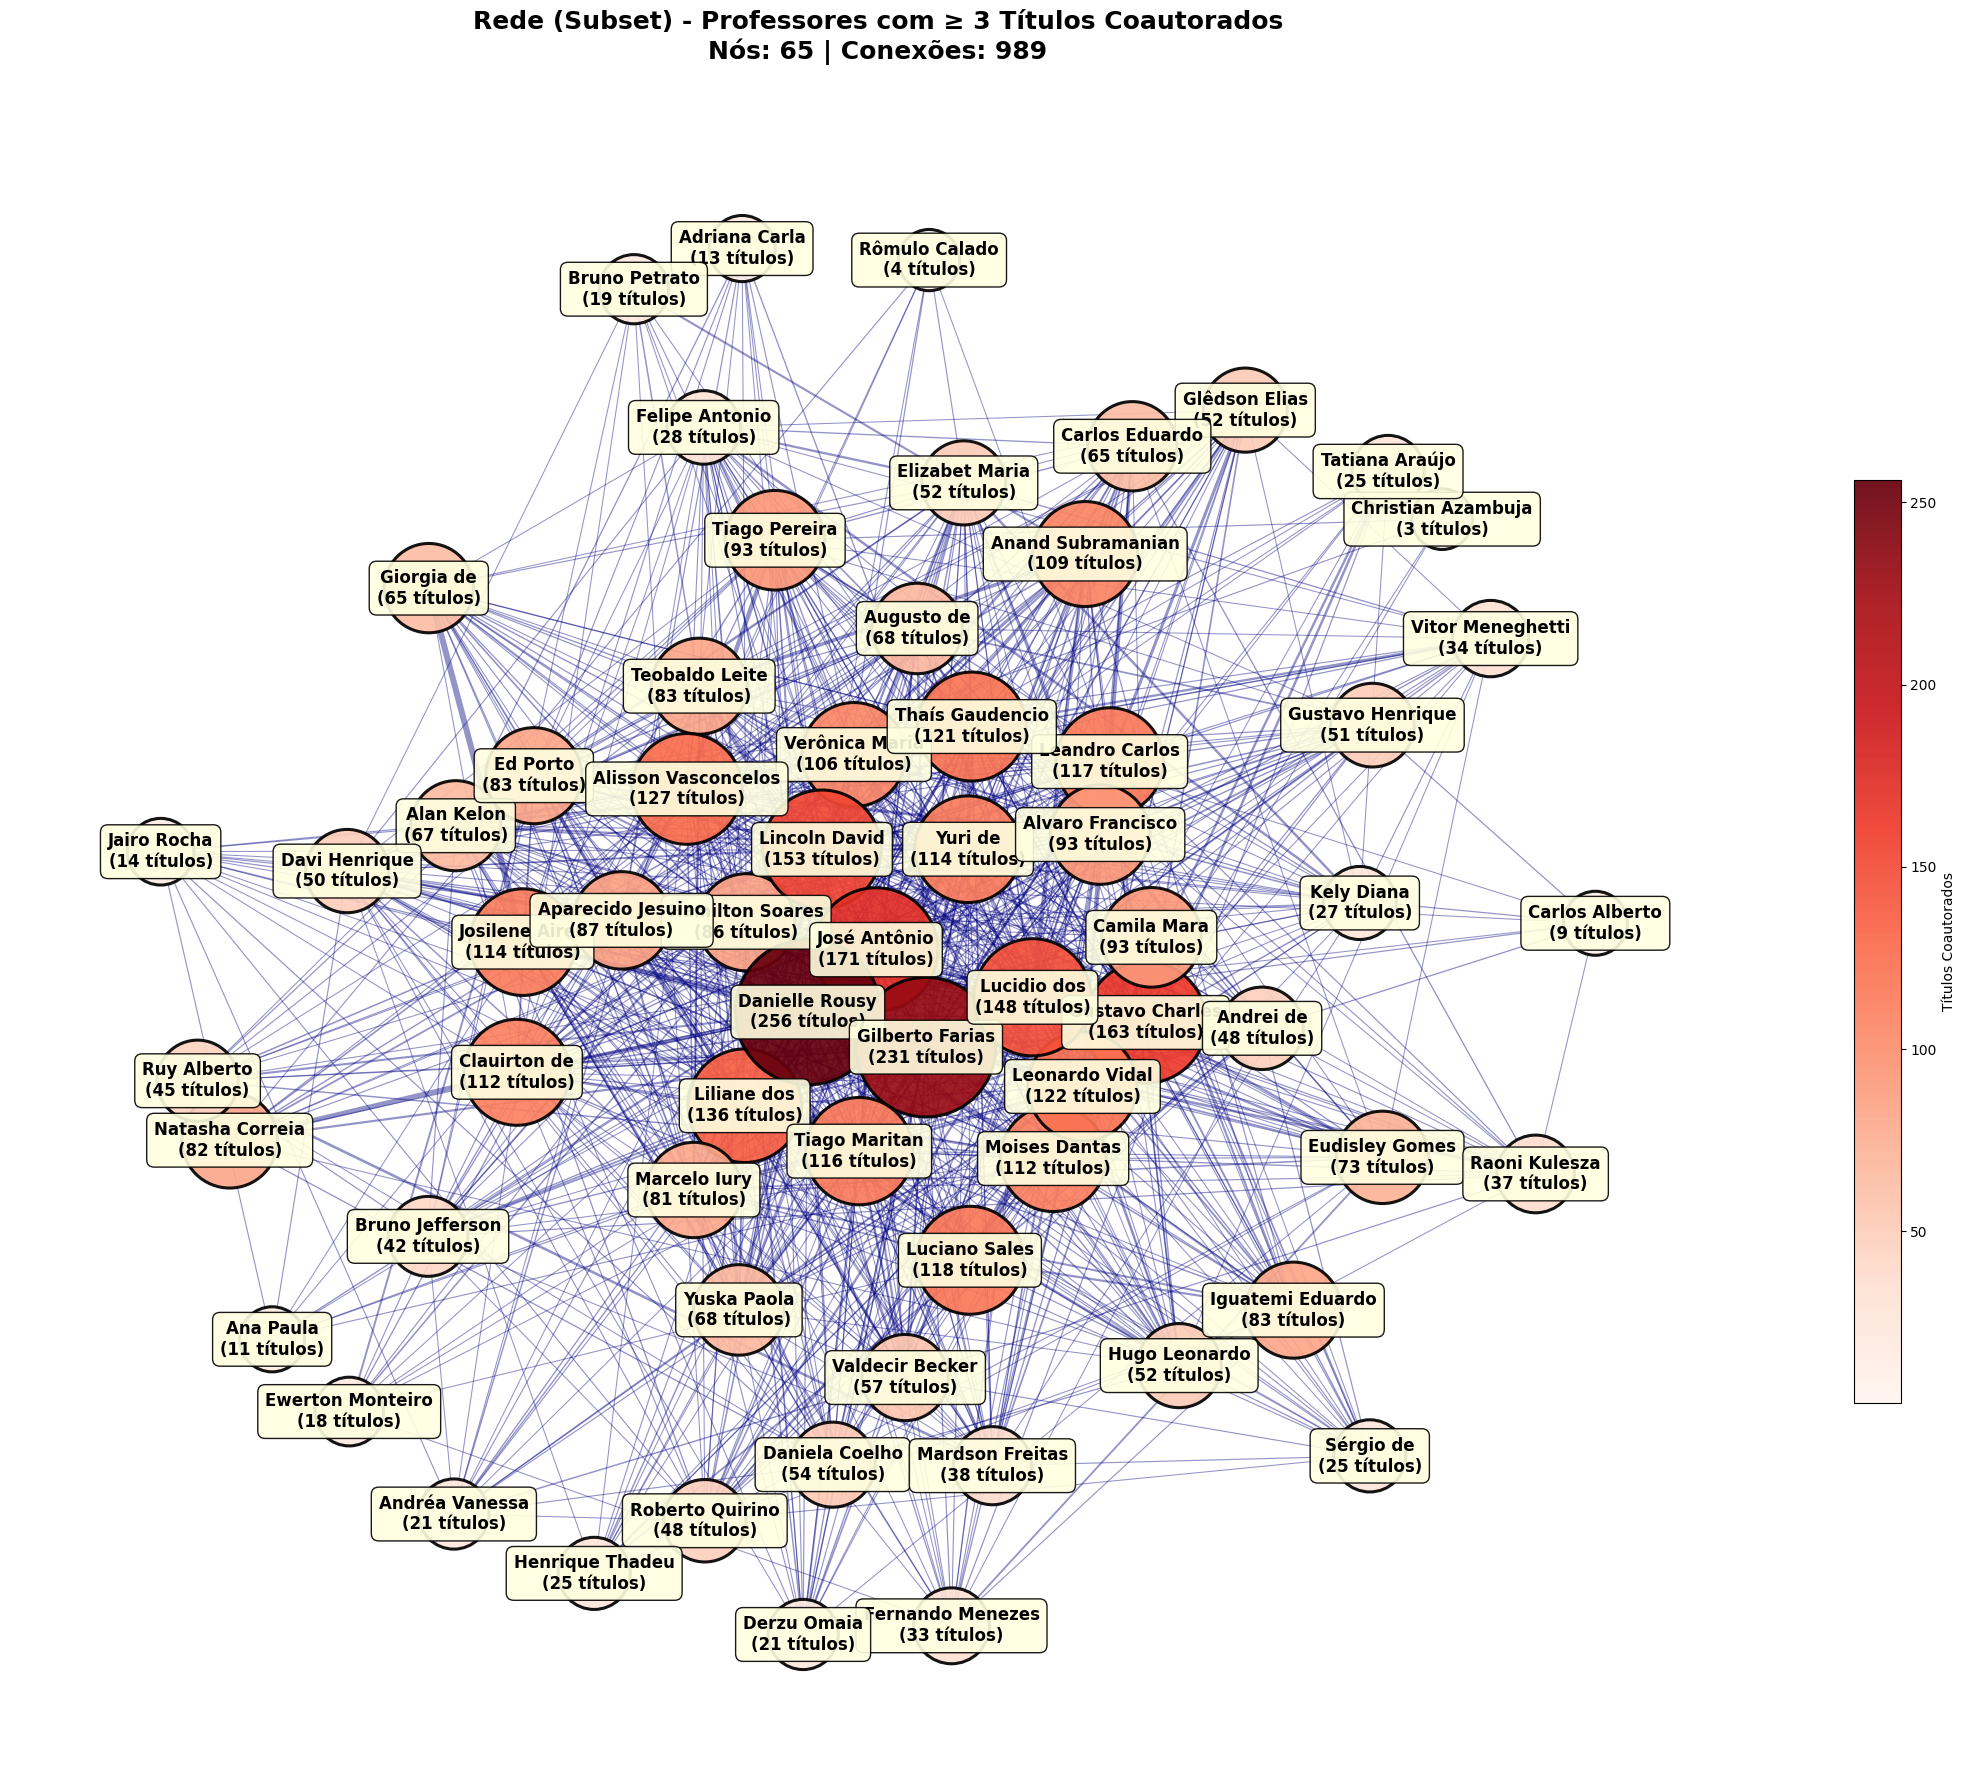

,Professor,Títulos Coautorados,Colaboradores Únicos,Total Colaborações (soma pesos),Publicações Totais
0,Danielle Rousy Dias Ricarte,256,59,456,291
1,Gilberto Farias de Sousa Filho,231,50,414,245
2,José Antônio Gomes de Lima,171,48,312,188
3,Gustavo Charles Peixoto de Oliveira,163,53,277,213
4,Lincoln David Nery e Silva,153,53,306,161
...,...,...,...,...,...
60,Adriana Carla Damasceno,13,11,22,50
61,Ana Paula Pintado Wyse,11,9,18,56
62,Carlos Alberto Nunes Machado,9,8,17,9
63,Rômulo Calado Pantaleão Camara,4,7,11,10


In [6]:
def criar_visualizacao_interativa_menor(G, metricas_nos):
    """
    Visualização focada somente em professores com >= 3 títulos coautorados.
    Tamanho do nó = títulos coautorados (critério atualizado com nós maiores).
    """
    nos_importantes = [
        n for n in G.nodes() if metricas_nos[n]["titulos_coautorados"] >= 3
    ]
    if len(nos_importantes) < 2:
        print("Não há professores suficientes com 3+ títulos coautorados.")
        return

    G_filtrado = G.subgraph(nos_importantes).copy()
    plt.figure(figsize=(22, 18))
    pos = nx.spring_layout(G_filtrado, k=18, iterations=350, seed=42)

    max_coauthored = (
        max(metricas_nos[n]["titulos_coautorados"] for n in G_filtrado.nodes())
        if G_filtrado.nodes()
        else 1
    )
    node_sizes = []
    node_colors = []
    edge_widths = []

    # AUMENTADO: antes 1200–5200
    min_size, max_size = 1800, 11000
    for n in G_filtrado.nodes():
        c = metricas_nos[n]["titulos_coautorados"]
        size = min_size + (max_size - min_size) * (c / max_coauthored)
        node_sizes.append(size)
        node_colors.append(c)

    # Arestas dimensionadas pelo peso (publicações conjuntas por par)
    if G_filtrado.edges():
        max_weight = max(
            G_filtrado[u][v].get("weight", 1) for u, v in G_filtrado.edges()
        )
        for u, v in G_filtrado.edges():
            w = G_filtrado[u][v].get("weight", 1)
            edge_widths.append(0.7 + 5 * (w / max_weight))

    nx.draw_networkx_edges(
        G_filtrado, pos, width=edge_widths, alpha=0.42, edge_color="navy"
    )
    nodes = nx.draw_networkx_nodes(
        G_filtrado,
        pos,
        node_size=node_sizes,
        node_color=node_colors,
        cmap=plt.cm.Reds,
        alpha=0.92,
        edgecolors="black",
        linewidths=2.2,
    )

    labels = {}
    for n in G_filtrado.nodes():
        c = metricas_nos[n]["titulos_coautorados"]
        partes = n.split()
        nome_curto = " ".join(partes[:2])
        labels[n] = f"{nome_curto}\n({c} títulos)"

    nx.draw_networkx_labels(
        G_filtrado,
        pos,
        labels,
        font_size=12,
        font_weight="bold",
        bbox=dict(boxstyle="round,pad=0.45", facecolor="lightyellow", alpha=0.9),
    )

    plt.colorbar(nodes, label="Títulos Coautorados", shrink=0.55)
    plt.title(
        "Rede (Subset) - Professores com ≥ 3 Títulos Coautorados\n"
        f"Nós: {len(G_filtrado.nodes())} | Conexões: {len(G_filtrado.edges())}",
        fontsize=18,
        fontweight="bold",
        pad=32,
    )
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    dados = [
        {
            "Professor": n,
            "Títulos Coautorados": metricas_nos[n]["titulos_coautorados"],
            "Colaboradores Únicos": metricas_nos[n]["grau"],
            "Total Colaborações (soma pesos)": metricas_nos[n]["total_colaboracoes"],
            "Publicações Totais": metricas_nos[n]["publicacoes"],
        }
        for n in G_filtrado.nodes()
    ]
    df = pd.DataFrame(dados).sort_values("Títulos Coautorados", ascending=False)
    display(df.reset_index(drop=True))


# Recriar visualização focada com nova escala de tamanhos
criar_visualizacao_interativa_menor(rede, metricas_nos)